# Modeling Capstone: Predicting Employee Attrition

The aim of this notebook is to build upon the data wrangling, exploratory data analysis, and preprocessing conducted with the IBM HR dataset for the purpose of predicting employee attrition. 

Several classification algorithms are explored, the most promising of which are tuned for increased predictive performance. The 'best' model as evaluated by standard metrics for classification models (accuracy, precision, recall, F1 Score, ROC AUC) is selected for use in addressing the questions proposed. 

Let's begin this the usual way, by importing the necessary libraries and modules.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report, precision_score, recall_score, f1_score

The cleaned HR dataset, test/train labels and features are imported from the prior preprocessing step.

In [2]:
# read in cleaned HR dataset & features
df = pd.read_csv('HR_data_Cleaned_EDA.csv')
features = pd.read_csv('features.csv')

idx_train = pd.read_csv('idx_train.csv').to_numpy()[:,1:]
idx_test = pd.read_csv('idx_test.csv').to_numpy()[:,1:]

# drop extra columns
df.drop(columns='Unnamed: 0', inplace=True)
features.drop(columns='Unnamed: 0', inplace=True)

# convert DataFrames to numpy arrays, flatten label arrays
X_train = pd.read_csv('X_train.csv').to_numpy()[:,1:]
X_test  = pd.read_csv('X_test.csv').to_numpy()[:,1:]

y_train = pd.read_csv('y_train.csv').to_numpy()[:,1:].ravel()
y_test  = pd.read_csv('y_test.csv').to_numpy()[:,1:].ravel()

# initialize model metrics and predictions DataFrames
model_metrics = pd.DataFrame()
model_predictions = pd.DataFrame()

To begin our model selection process, we will calculate 5-fold Cross-Validation (CV) scores on five standard classification algorithms (below), without significantly tuning hyperparameters. This will aid us in selecting a model that generalizes well without significant overfitting (low variance).

We will select the algorithm with the highest overall CV score for use as our most promising baseline classification model.

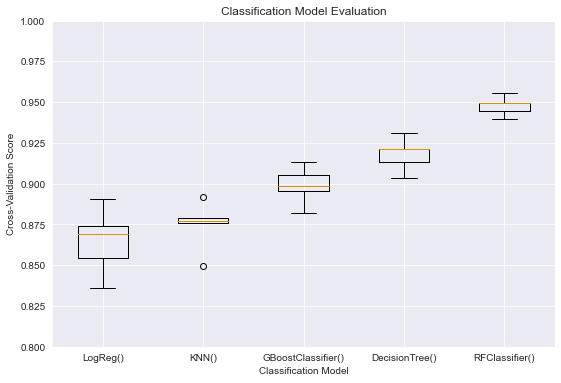

In [3]:
# instantiate model dictionary and fill with five base classification algorithms 
models = {"LogReg()": LogisticRegression(max_iter=200), "KNN()": KNeighborsClassifier(), "GBoostClassifier()": GradientBoostingClassifier(), "DecisionTree()": DecisionTreeClassifier() ,"RFClassifier()": RandomForestClassifier()}

# instantiate cross-validation results list
results = []

# iterate through the models and perform 5-fold CV
for model in models.values():
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kf)
    # append the five CV scores for each model to the results list
    results.append(cv_results)

# generate a barplot to visualize CV scores by model
_ = plt.figure(figsize=(9,6))

sns.set_style('darkgrid')
sns.set_palette('colorblind')

plt.boxplot(results, labels=models.keys())
plt.title('Classification Model Evaluation')
plt.xlabel('Classification Model')
plt.ylabel('Cross-Validation Score')
plt.ylim([0.80, 1.00])
plt.show()

As shown above, the RandomForestClassifier() performed the best of the 5 classification models during cross-validation.

We will proceed with the RandomForestClassifier() as our baseline model. First, let's fit the model with no hyperparameter tuning to get a set of rerference baseline performance metrics.

# Model A: RFClasssifier() - Baseline, no optimization

Confusion Matrix: 
 [[1096    3]
 [  48  164]] 

Accuracy : 0.961
Precision: 0.982
Recall   : 0.774
F1-Score : 0.865
ROC AUC Score: 0.9897247926931859

Classification Report: 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      1099
           1       0.98      0.77      0.87       212

    accuracy                           0.96      1311
   macro avg       0.97      0.89      0.92      1311
weighted avg       0.96      0.96      0.96      1311



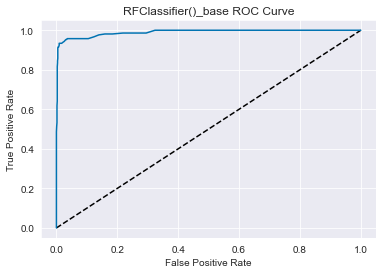

In [4]:
# Model A: RFClasssifier() - base case, no optimization
model_name = 'RFClassifier()_base'

# instantiate the RandomForestClassifier()
rf_base = RandomForestClassifier()

# fit the RandomForestClassifier() with no parameter tuning
rf_base.fit(X_train, y_train)

# generate predictions
y_pred = rf_base.predict(X_test)

# get predictions as probabilities
y_pred_probs = rf_base.predict_proba(X_test)[:, 1]

# Model A Evaluation
conf_m    = confusion_matrix(y_test, y_pred)
accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall    = recall_score(y_test, y_pred)
f1        = f1_score(y_test, y_pred)
report    = classification_report(y_test, y_pred)

model_metrics[model_name]  = pd.Series({'conf':[conf_m], 'accuracy': accuracy,
                                'precision': precision, 'recall': recall,
                                'f1': f1})

model_predictions[model_name] = pd.Series({'y_pred':[y_pred], 'y_prob':[y_pred_probs]})

print('Confusion Matrix: \n',conf_m, '\n')
print('Accuracy : %.3f'%accuracy)
print('Precision: %.3f'%precision)
print('Recall   : %.3f'%recall)
print('F1-Score : %.3f'%f1)
print('ROC AUC Score: {}'.format(roc_auc_score(y_test, y_pred_probs)))
print('\nClassification Report: \n', report)

# calculate and plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
sns.set_style('darkgrid') 
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('{} ROC Curve'.format(model_name))
plt.show()

The base case RFClassifier did exceptionally well considering no parameters were tuned, achieving especially high accuracy (0.969) and precision (0.983) on the test set.

Let's see if we can improve our performance metrics through some hyperparameter tuning. We will use RandomizedGridSearchCV to test a wide range of parameter combinations with relatively less impact on computation time.

# Hyperparameter Tuning: RandomizedGridSearchCV()

In [5]:
# RFClasssifier(): Hyperparameter tuning via RandomizedGridSearchCV

# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

# number of features to consider at every split
max_features = ['auto', 'sqrt']

# maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(20, 200, num = 5)]

# minimum number of samples required to split a node
min_samples_split = [2, 5, 7]

# minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# create random_grid dictionary with hyperparameters to be tested
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# set value for number CV folds and iterations
kf = 5
rf_iterations = 100

# instantiate the base RandomForestClassifier model
rf = RandomForestClassifier()

# use RandomizedSearchCV to narrow down best hyperparameter combinations
rf_rand = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = rf_iterations, cv = kf, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_rand.fit(X_train, y_train)

# print the best hyperparameters for reference
print(rf_rand.best_params_, rf_rand.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 110} 0.946663564498358


My computer definitely broke a sweat on that one. 
Fortunately, we have a set of optimal parameters identified during our randomized grid search cross-validation. Let's use them to tune our RFClassifier() and assess performance improvements.

# Model B: RFClasssifier() - GridSearch Optimized Parameters

Confusion Matrix: 
 [[1095    4]
 [  43  169]] 

Accuracy : 0.964
Precision: 0.977
Recall   : 0.797
F1-Score : 0.878
ROC AUC Score: 0.9890402080793861

Classification Report: 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      1099
           1       0.98      0.80      0.88       212

    accuracy                           0.96      1311
   macro avg       0.97      0.90      0.93      1311
weighted avg       0.96      0.96      0.96      1311



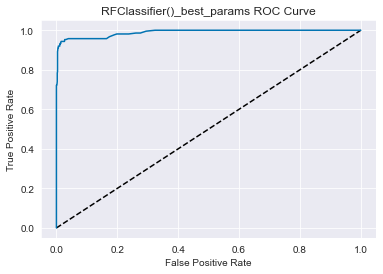

In [6]:
# Model B: RFClasssifier() - 'best' (optimized) parameters
model_name = 'RFClassifier()_best_params'

# instantiate a new RandomForestClassifier() model
rf_best = RandomForestClassifier()

# Set model parameters to optimized params 
rf_best.set_params(**rf_rand.best_params_)

# re-fit model with optimized parameters 
rf_best.fit(X_train, y_train)

# generate predictions
y_pred = rf_best.predict(X_test)

# generate predictions as probabilites
y_pred_probs = rf_best.predict_proba(X_test)[:, 1]
 
# Model B Evaluation
conf_m    = confusion_matrix(y_test, y_pred)
accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall    = recall_score(y_test, y_pred)
f1        = f1_score(y_test, y_pred)
report    = classification_report(y_test, y_pred)

model_metrics[model_name]  = pd.Series({'conf':[conf_m], 'accuracy': accuracy,
                                'precision': precision, 'recall': recall,
                                'f1': f1})

model_predictions[model_name] = pd.Series({'y_pred':[y_pred], 'y_prob':[y_pred_probs]})

print('Confusion Matrix: \n',conf_m, '\n')
print('Accuracy : %.3f'%accuracy)
print('Precision: %.3f'%precision)
print('Recall   : %.3f'%recall)
print('F1-Score : %.3f'%f1)
print('ROC AUC Score: {}'.format(roc_auc_score(y_test, y_pred_probs)))
print('\nClassification Report: \n', report)

# calculate and plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
sns.set_style('darkgrid')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('{} ROC Curve'.format(model_name))
plt.show()

The optimized RFClassifier performed roughly the same as the base case, and worse in some metrics (accuracy, precision). Let's turn our focus to improving feature quality by selecting the most important features for a leaner model.

# Improving Feature Quality: Feature Selection by Importance

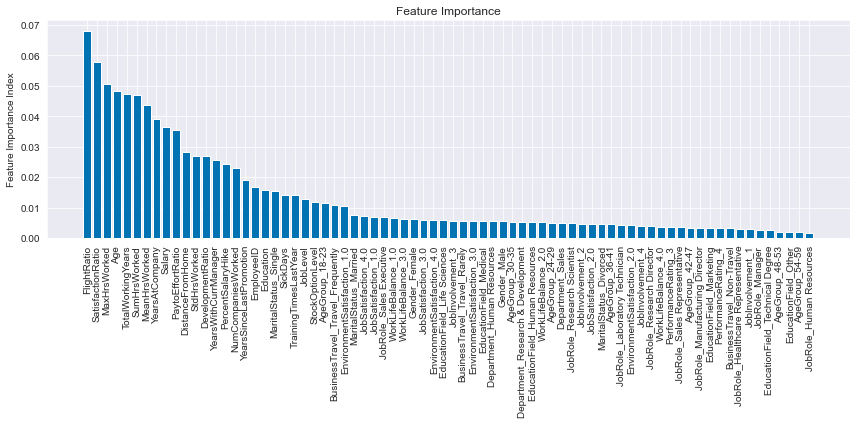

In [7]:
# Using RandomForestClassifier() to Visualize Feature Importances 
 
# get feature importances
importances = rf_best.feature_importances_

# sort the feature importance in descending order
sorted_indices = np.argsort(importances)[::-1]

# visualize feature importances
_ = plt.figure(figsize=(12,6))
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), features.iloc[sorted_indices,0], rotation=90)
plt.ylabel('Feature Importance Index')
plt.tight_layout()
plt.show()

As shown above, many of the 72 features in use offer little predictive power to our model. We will select the top 20 most predicitve features by importance to improve model runtime.

In [8]:
# RFClassifier(): Selecting most important features

# feature selection: top 20 most important features
top_features = pd.DataFrame({'Feature': features.iloc[sorted_indices[0:20],0]})
 
# Re-assign feature arrays with top 20 features only
X_train_top = X_train[:,top_features.index] 
X_test_top = X_test[:,top_features.index] 

Now, let's see how much if any predictive power is sacrified by removing low-importance features, remember we've reduced the number of features by ~72%.

We will test this by creating another RandomForestClassifier() with optimized parameters which will be trained on only the top 20 most important features.

# Model C: RFClasssifier() - Optimized Parameters & Features

Confusion Matrix: 
 [[1095    4]
 [  59  153]] 

Accuracy : 0.952
Precision: 0.975
Recall   : 0.722
F1-Score : 0.829
ROC AUC Score: 0.9807050148505502

Classification Report: 
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      1099
           1       0.97      0.72      0.83       212

    accuracy                           0.95      1311
   macro avg       0.96      0.86      0.90      1311
weighted avg       0.95      0.95      0.95      1311



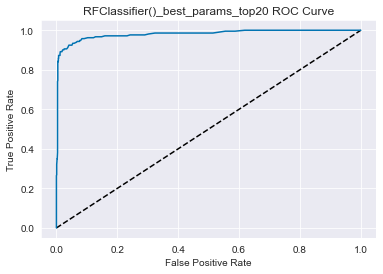

In [9]:
# Model C: RFClasssifier() - optimized parameters & optimized features
model_name = 'RFClassifier()_best_params_top20'

# Rerun model with best params and top 20 features only
rf_best_top20 = RandomForestClassifier()
rf_best_top20.set_params(**rf_rand.best_params_)

rf_best_top20.fit(X_train_top, y_train)

y_pred = rf_best_top20.predict(X_test_top)
y_pred_probs = rf_best_top20.predict_proba(X_test_top)[:, 1]
 
# Model C Evaluation
conf_m    = confusion_matrix(y_test, y_pred)
accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall    = recall_score(y_test, y_pred)
f1        = f1_score(y_test, y_pred)
report    = classification_report(y_test, y_pred)

model_metrics[model_name]  = pd.Series({'conf':[conf_m], 'accuracy': accuracy,
                                'precision': precision, 'recall': recall,
                                'f1': f1})

model_predictions[model_name] = pd.Series({'y_pred':[y_pred], 'y_prob':[y_pred_probs]})

print('Confusion Matrix: \n',conf_m, '\n')
print('Accuracy : %.3f'%accuracy)
print('Precision: %.3f'%precision)
print('Recall   : %.3f'%recall)
print('F1-Score : %.3f'%f1)
print('ROC AUC Score: {}'.format(roc_auc_score(y_test, y_pred_probs)))
print('\nClassification Report: \n', report)

# calculate and plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
sns.set_style('darkgrid')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('{} ROC Curve'.format(model_name))
plt.show()

While performance overall declined marginally, this is our best model so far due to the significant reduction in features.

Let's continue our exploration by creating a LogisticRegression() model, evaluating its baseline score, and attempting to improve it through use of optimized parameters and features.

C:\Users\Charles\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix: 
 [[1047   52]
 [ 137   75]] 

Accuracy : 0.856
Precision: 0.591
Recall   : 0.354
F1-Score : 0.442
ROC AUC Score: 0.8016593129259876

Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.95      0.92      1099
           1       0.59      0.35      0.44       212

    accuracy                           0.86      1311
   macro avg       0.74      0.65      0.68      1311
weighted avg       0.84      0.86      0.84      1311



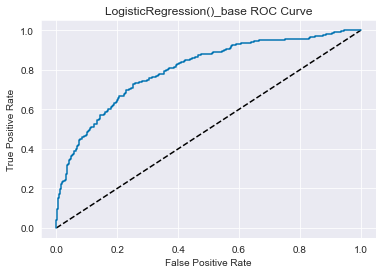

In [10]:
 
# Model X: LogisticRegression(): 
model_name = 'LogisticRegression()_base'
    
logreg_base = LogisticRegression()
logreg_base.fit(X_train, y_train)

y_pred = logreg_base.predict(X_test)
y_pred_probs = logreg_base.predict_proba(X_test)[:, 1]

# Model X Evaluation
conf_m    = confusion_matrix(y_test, y_pred)
accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall    = recall_score(y_test, y_pred)
f1        = f1_score(y_test, y_pred)
report    = classification_report(y_test, y_pred)

model_metrics[model_name]  = pd.Series({'conf':[conf_m], 'accuracy': accuracy,
                                'precision': precision, 'recall': recall,
                                'f1': f1})

model_predictions[model_name] = pd.Series({'y_pred':[y_pred], 'y_prob':[y_pred_probs]})

print('Confusion Matrix: \n',conf_m, '\n')
print('Accuracy : %.3f'%accuracy)
print('Precision: %.3f'%precision)
print('Recall   : %.3f'%recall)
print('F1-Score : %.3f'%f1)
print('ROC AUC Score: {}'.format(roc_auc_score(y_test, y_pred_probs)))
print('\nClassification Report: \n', report)

# calculate and plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
sns.set_style('darkgrid')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('{} ROC Curve'.format(model_name))
plt.show()

C:\Users\Charles\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Charles\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Charles\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Charles\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError

Confusion Matrix: 
 [[1071   28]
 [ 161   51]] 

Accuracy : 0.856
Precision: 0.646
Recall   : 0.241
F1-Score : 0.351
ROC AUC Score: 0.7657261318179477

Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.97      0.92      1099
           1       0.65      0.24      0.35       212

    accuracy                           0.86      1311
   macro avg       0.76      0.61      0.63      1311
weighted avg       0.83      0.86      0.83      1311



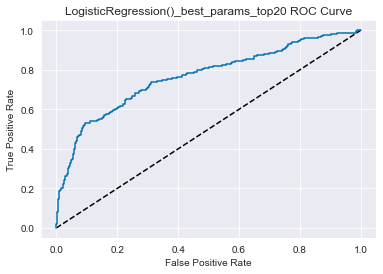

In [11]:
# Model X: LogisticRegression()_best_params_top20: 
model_name = 'LogisticRegression()_best_params_top20'

params = [{'penalty':['l1','l2']}, 
              {'C':[1, 10, 100, 1000]}]

logreg_best_top20 = LogisticRegression()
logreg_best_top20 = GridSearchCV(estimator = logreg_best_top20, param_grid = params, scoring = 'accuracy', cv = 5, verbose=0)

logreg_best_top20.fit(X_train_top, y_train)  

y_pred = logreg_best_top20.predict(X_test_top)
y_pred_probs = logreg_best_top20.predict_proba(X_test_top)[:, 1]

# Model X Evaluation
conf_m    = confusion_matrix(y_test, y_pred)
accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall    = recall_score(y_test, y_pred)
f1        = f1_score(y_test, y_pred)
report    = classification_report(y_test, y_pred)

model_metrics[model_name]  = pd.Series({'conf':[conf_m], 'accuracy': accuracy,
                                'precision': precision, 'recall': recall,
                                'f1': f1})

model_predictions[model_name] = pd.Series({'y_pred':[y_pred], 'y_prob':[y_pred_probs]})

print('Confusion Matrix: \n',conf_m, '\n')
print('Accuracy : %.3f'%accuracy)
print('Precision: %.3f'%precision)
print('Recall   : %.3f'%recall)
print('F1-Score : %.3f'%f1)
print('ROC AUC Score: {}'.format(roc_auc_score(y_test, y_pred_probs)))
print('\nClassification Report: \n', report)

# calculate and plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
sns.set_style('darkgrid')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('{} ROC Curve'.format(model_name))
plt.show()

Unfortunately, both of the LogisticRegression() models didn't perform as well as the RandomForestClassifiers(), which was not a surprising result based upon our initial cross-validation scoring of various models conducted at the beginning of this notebook.

Let's compile our scoring metric data from each model tested and proceed with our final model evaluations.

# Model Evaluation: Confusion Matrices

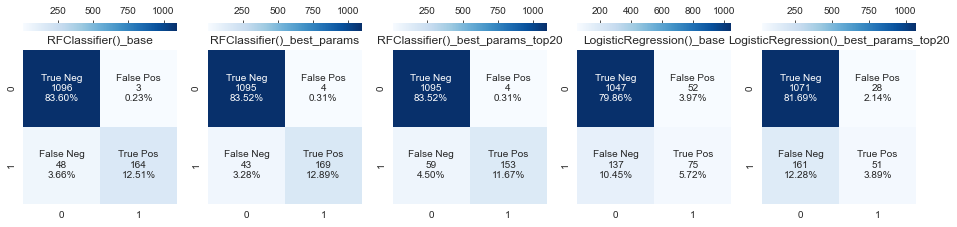

In [12]:
# Visualization: Confusion Matricies
fig, axes = plt.subplots(1, 5, sharex=True, figsize=(16,7)) 

for i in range(0, 5):
    
    y_pred = model_predictions.iloc[0,i][0]
    cf_matrix = confusion_matrix(y_test, y_pred)
    
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    sns.heatmap(cf_matrix, ax=axes[i], annot=labels, fmt='', cmap='Blues', cbar=True, square=True, cbar_kws = dict(use_gridspec=False,location="top"))
    _ = axes[i].set_title(model_predictions.columns[i], fontsize=12)
    

Upon review of the ConfusionMatrices from the 5 models scored, we can argue that our 'best' model was the RandomForestClassifier() model with RandomizedGridSearchCV() optimized parameters and use of the 20 most important features. We have selected this model because it performed almost as well as the RFClassifier with all 72 features, but with a significantly lower data volume requirement.

Next, let's visualize our classification performance metrics 'accuracy, precision, recall, f1) across models.

# Model Evaluation: Classification Metrics

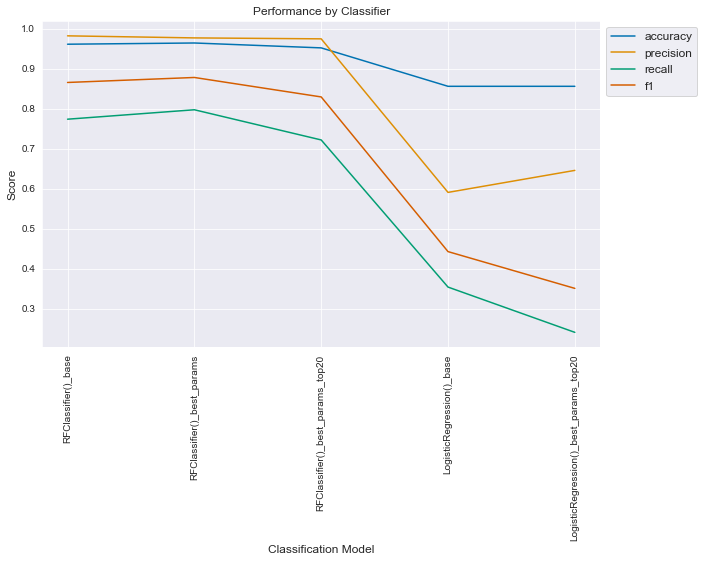

In [13]:
# Get classification metrics
model_performance = model_metrics.T[['accuracy','precision','recall','f1']]
model_performance = model_performance.reset_index()

# Visualization: Classification Metrics
_ = plt.figure(figsize=(10,6))

sns.set_style('darkgrid')
sns.set_palette('colorblind')

sns.lineplot(x='index', y='accuracy', data=model_performance)
sns.lineplot(x='index', y='precision', data=model_performance)
sns.lineplot(x='index', y='recall', data=model_performance)
sns.lineplot(x='index', y='f1', data=model_performance)
plt.xticks(rotation=90)
plt.ylabel('Score', fontsize=12)
plt.xlabel('Classification Model', fontsize=12)
plt.title('Performance by Classifier', fontsize=12)
plt.legend(model_performance.columns[1:], bbox_to_anchor=(1,1), fontsize=12)
plt.show()

# Best model: RandomForestClassifier() using RandomSearchCV parameters and top 20 most important features.

     

Again, we can confirm what we stated above and state that our best model was the optimized 20-feature RandomForestClassifier().

Let's proceed by using our model to answer the two key questions queried in the proposal for this analysis.

# Proposal Evaluation I: Key Features

Question I:
What are the 5 most important features influencing the probability of an employee's attrition?

In [20]:
# index for the top 5 features from the best-performing RandomForestClassifier() model
top_features.reset_index(inplace=True)
top_five = top_features.loc[0:4,'Feature']

# print the results
print('The 5 most predictive features influencing an employees probability of attrition are: \
{}, {}, {}, {}, and {}.'.format(top_five[0], top_five[1], top_five[2], top_five[3], top_five[4]))

The 5 most predictive features influencing an employees probability of attrition are: FlightRatio, SatisfactionRatio, MaxHrsWorked, Age, and TotalWorkingYears.


Two of the five features (FlightRatio, SatisfactionRatio), are engineered. Descriptions these features and their components are below:

$$
  [FlightRatio] = \frac{[NumCompaniesWorked]}{[TotalWorkingYears]*[EnvironmentSatisfaction]}
$$

$$
  [SatisfactionRatio] = \frac{[WorkLifeBalance]*[EnvironmentSatisfaction]*[JobSatisfaction]}{[MeanHrsWorked]}
$$


# Proposal Evaluation II: Employee Identification

Question II: Can we identify employees within the upper 20th percentile who are most likely to leave the company?

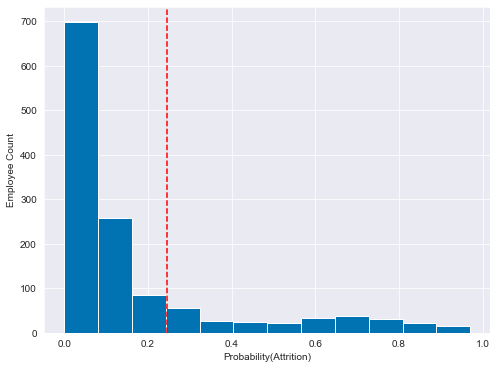

In [15]:
# get predicted attrition probabilites from the best-performing RandomForestClassifier() model
att_probs = pd.Series(model_predictions.loc['y_prob','RFClassifier()_best_params_top20'][0])

# get employee ids saved during the train_test_split
emp_ids = pd.Series(idx_test.ravel())

# concatenate the Series to form a cohesive DataFrame with IDs and attrition probabilities
att_by_employee = pd.concat([emp_ids, att_probs], axis=1)
att_by_employee.columns = ['EmployeeID', 'Probability']

# calculate the 80th percentile (upper 20%) of attrition probability
quantile_80 = att_by_employee.quantile([0.8], axis = 0)['Probability'].loc[0.80]

# filter for employees above the 80th percentile
emp_above_80 = att_by_employee[att_by_employee['Probability'] >= quantile_80]

# plot the histogram of attrition probabilites by employee
_ = plt.figure(figsize=(8,6))
sns.set_style('darkgrid')

# mark the x-axis dividing employees above and below the 80th percentile
plt.hist(att_by_employee['Probability'], bins=12)
plt.axvline(quantile_80, c='r', linestyle='--')
plt.xlabel('Probability(Attrition)')
plt.ylabel('Employee Count')
plt.show()